# Deep Learning Approach to HAZMAT Label Detection with Synthetic Dataset Generation Techniques Accounting for Obstruction, Distortion, Crumpling, or Incompletion

### Abstract
A robust HAZMAT label detection system is required by industries. While other research focuses on intact HAZMAT labels, my research into HAZMAT label detection includes the possibility of obstructed, crumpled, or incomplete labels. These HAZMAT labels are present in real-world scenarios, and a robust algorithm that takes care of these cases is very valuable. In order to achieve this variability, I wrote code to generate new image data as the model trains. My results provides evidence that Deep Learning CNNs can account for obstructed labels, distorted labels, crumped labels, or incomplete labels. Generally, my results provides evidence that Deep Learning CNNs can be used in object identification applications where objects are obstructed, crumpled, distorted, or incomplete. As training loss on the synthetically generated dataset decreases, the testing accuracy of the real data set increases substantially. Therefore, my results provides evidence that my methods of generating a dataset is a good way to approximate the real data set of HAZMAT labels.

### Introduction
HAZMAT labels are labels used on packaging to indicate hazardous materials. An automatic, fast, and accurate system that detects HAZMAT labels will benefit industry. The safety of shipments depend on the accuracy of such system. 

While other research focuses on intact HAZMAT labels, my research into HAZMAT label detection includes the possibility of obstructed, crumpled, or incomplete labels. These HAZMAT labels are present in real-world scenarios, and a robust algorithm that takes care of these cases is very valuable

### Goals
- Approximate real-world images with synthetic data generation, accounting for cases such as lighting, rotation, noise, shadow, obstruction, distortion, crumpling, or incompletion. Determine if the synthetically generated dataset is a good approximation of real-world scenarios using the public HTLID dataset as a testing benchmark.
- Determine the viability of Deep Learning approaches in HAZMAT label recognition

### Similar Research
- This paper [1] have shown that SIFT based algorithms with attentional preselection have found success in HAZMAT label detection. Their approach accounts for very difficult lighting situations. My research also accounts for these lighting situations, but approaches this problem through Deep Learning.
- This paper [2] uses a deep learning based approach. They used YOLOV3 [3], a model optimized for speed and designed for real-time object detection. Their approach accounts for rotated and blurred images, while my research includes obstructed, crumbled, or missing images.

### Summary of Approach (A detailed implementation can be viewed below)
Synthetic data generation consists of these steps:
- Generate creases in a batch of labels to simulate crumpled HAZMAT labels
- Generate a mask to simulate incomplete HAZMAT labels
- Combine labels with random background images
- Add a random brightness and hue to simulate different lightings and different color schemes
- Add Gaussian noise. This adds a normalization effect
- Apply a shadow
- Take a random 128x128 section of the 150x150 image
- Simulate lighting of the background image
- Add obstructions

Models are pre-trained on the imageNet challenge. Models are trained in tensorflow/keras on a NVIDIA GeForce RTX 2080 GPU.



### Findings
- The network that performed the best on this application is InceptionV3 with a testing accuracy of 81.5%.
- My results provides evidence that Deep Learning CNNs can account for obstructed labels, distorted labels, crumped labels, or incomplete labels.
- Generally, my results provides evidence that Deep Learning CNNs can be used in object identification applications where objects are obstructed, crumpled, distorted, or incomplete
- As training loss on the synthetically generated dataset decreases, the testing accuracy of the real data set increases substantially. Therefore, my results provides evidence that I have created an artificially generated dataset that is a good approximation of the real data set of HAZMAT labels.
- A complex model such as the InceptionResNetV2 seems to be overfitting the generated dataset and not generalizing to real-world data

| Model                 | Size (MB) | Training images | Generated Dataset Loss | Testing Loss | Generated Dataset Accuracy | Testing Accuracy |
|-----------------------|-----------|-----------------|------------------------|--------------|----------------------------|------------------|
| InceptionResNetV2 [4] | 625       | 500,000         | 0.041                  | 1.269        | 0.989                      | 0.752            |
| InceptionV3 [5]       | 252       | 1,200,000       | 0.071                  | 0.941        | 0.978                      | 0.815            |
| ResNet50V2 [6]        | 271       | 1,200,000       | 0.098                  | 1.412        | 0.967                      | 0.698            |
| MobileNetV2 [7]       | 27        | 800,000         | 0.114                  | 3.896        | 0.966                      | 0.397            |

### Citations
[1] Mohamed, M. A., et al. “Seeing Signs of Danger: Attention-Accelerated Hazmat Label Detection.” 2018 IEEE International Symposium on Safety, Security, and Rescue Robotics (SSRR), 2018, pp. 1–6. IEEE Xplore, doi:10.1109/SSRR.2018.8468639.

[2] Edlinger, Raimund, et al. “Hazmat Label Recognition and Localization for Rescue Robots in Disaster Scenarios.” Electronic Imaging, vol. 2019, no. 7, Jan. 2019, pp. 463-1-463–66. IngentaConnect, doi:10.2352/ISSN.2470-1173.2019.7.IRIACV-463.

[3] Redmon, Joseph, and Ali Farhadi. “YOLOv3: An Incremental Improvement.” ArXiv:1804.02767 [Cs], Apr. 2018. arXiv.org, http://arxiv.org/abs/1804.02767.

[4] Szegedy, Christian, et al. “Inception-v4, Inception-ResNet and the Impact of Residual Connections on Learning.” ArXiv:1602.07261 [Cs], Aug. 2016. arXiv.org, http://arxiv.org/abs/1602.07261.

[5] Szegedy, Christian, et al. “Rethinking the Inception Architecture for Computer Vision.” ArXiv:1512.00567 [Cs], Dec. 2015. arXiv.org, http://arxiv.org/abs/1512.00567.

[6] He, Kaiming, et al. “Deep Residual Learning for Image Recognition.” ArXiv:1512.03385 [Cs], Dec. 2015. arXiv.org, http://arxiv.org/abs/1512.03385.

[7] Sandler, Mark, et al. “MobileNetV2: Inverted Residuals and Linear Bottlenecks.” ArXiv:1801.04381 [Cs], Mar. 2019. arXiv.org, http://arxiv.org/abs/1801.04381.


# Code / Detailed Implementation

In [1]:
# Importing Libraries
from random import random
import numpy as np
import scipy.misc
import cv2
from math import floor, ceil, exp, log, pi, cos, sin
from skimage.color import rgba2rgb
from skimage.io import imread, imshow
from skimage.transform import resize
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D
from tensorflow import keras
import os
from skimage import img_as_ubyte, img_as_float
from scipy.ndimage import rotate
from matplotlib import pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


# Section 1: Synthetic Data Generation
In this section, I will be generating a HAZMAT label dataset used to train my model.

### Examples of HAZMAT labels

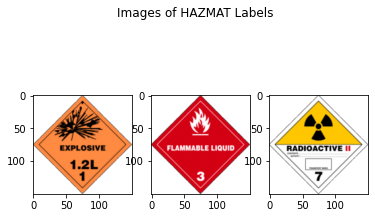

In [2]:
# Load images of hazmat labels
pics = np.load("pics.npy")
# Append null labels
pics = np.concatenate((pics, np.zeros((2,150,150,4))), axis=0)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Images of HAZMAT Labels')
ax1.imshow(pics[20])
ax2.imshow(pics[45])
ax3.imshow(pics[56])
plt.show()

### Examples of background images
These HAZMAT labels will be placed in background images. Each batch of image is 64 images. I have previously generated 33,000 batches of 2 million background images using the Flickr8k dataset. Here is a function that gets a batch of 64 background images.

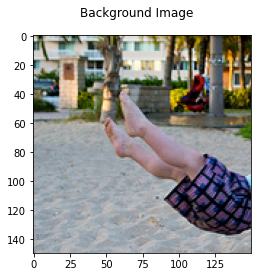

In [3]:
# Get a random batch of background images of shape (64, 150, 150, 3)
bgs_path = os.listdir("bgs")
num_bg = len(bgs_path)
def get_bg():
    random_index = floor(num_bg*random())
    path = "bgs/{}".format(bgs_path[random_index])
    return img_as_float(np.load(path))

# Show a background image
plt.figure()
plt.suptitle('Background Image')
plt.imshow(get_bg()[0])
plt.show()

### Rotation

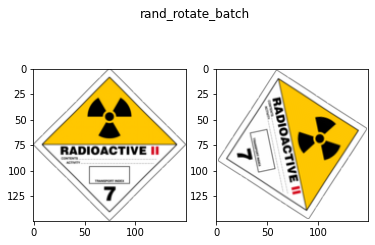

In [4]:
# Rotates a batch of pictures randomly
def rand_rotate_batch(imgs): 
    angle = random()*360
    imgs = rotate(imgs, angle, reshape=False, mode='constant', cval=0., axes=(1,2))
    return np.clip(imgs, 0, 1)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('rand_rotate_batch')
ax1.imshow(pics[56])
ax2.imshow(rand_rotate_batch(pics)[56])
plt.show()

### Noise

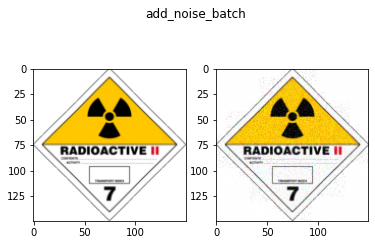

In [5]:
# Adds Gaussian noise to a batch of images, serves as normalization
def add_noise_batch(imgs, scale=0.05):
    new_imgs = np.random.normal(imgs, scale)
    new_imgs = np.clip(new_imgs, 0, 1)
    return new_imgs

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('add_noise_batch')
ax1.imshow(pics[56])
ax2.imshow(add_noise_batch(pics)[56])
plt.show()

### Brightness and Hue Shift

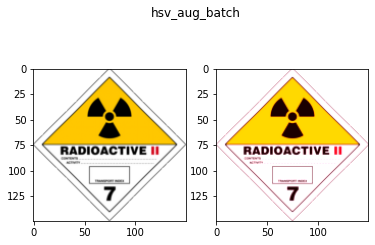

In [6]:
# RGBA (Red Green Blue Alpha) to RGB for a batch of pictures of size (batch_size, height, width, 4)
def rgba2rgb_batch(imgs):
    alpha = imgs[:,:,:,3:4]
    stripped = imgs[:,:,:,0:3]
    new_imgs = (1 - alpha) + alpha * stripped
    return new_imgs, alpha

# Random brightness and color shift
def hsv_aug_rgb_batch(img_batch):
    return np.clip(img_batch * (0.8 + np.random.random(size=(img_batch.shape[0],1,1,1)) * 0.4) 
                   + np.random.normal(0, 0.1, (img_batch.shape[0],1,1,3)), 0, 1) 


picsrgb, alpha = rgba2rgb_batch(pics)
picsrgb = hsv_aug_rgb_batch(picsrgb)

from matplotlib.colors import hsv_to_rgb
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('hsv_aug_batch')
ax1.imshow(pics[56])
ax2.imshow(picsrgb[56])
plt.show()

### Shadow Generation
The code below generates a random shadow for a batch of images.

I first generate random points. Using an matrix mapping, I calculate the corresponding random 5th degree polynomial. This polynomial will serve as the shadow

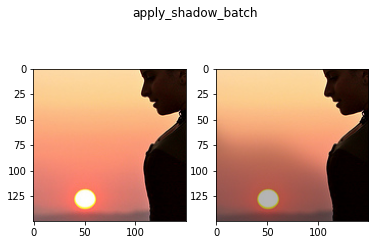

In [7]:
# Sigmoid function with a varied rate
def sigmoid(x, rate):
    return 1/(1+np.exp(-rate*x))

# Create Mapping A_inv from a set of points to a 5th degree polynomial
A = np.array([4,3,2,1,0])
B = np.array([0,38,75,113,150]).reshape((5,1))
C = np.zeros((5, 1))
P = C + A
A = np.power(B,P)
A_inv = np.linalg.inv(A)

# Used later to apply shadow
I = np.linspace(0, 149, 150, dtype=np.float64).reshape(1,150,1,1)
J = np.linspace(0, 149, 150, dtype=np.float64).reshape(1,1,150,1)

def apply_shadow_batch(img):
    
    shadow = 0.5*random()  # How dark the shadow is
    rate = 0.1 + 0.4*random()  # How sharp the shadow is

    # Random points X chosen where the shadow passes through
    X = np.random.normal(75, 25, (5,))
    # Create a the polynomial of the shadow based on the random points X
    p = np.poly1d(np.dot(A_inv, X))
    
    # Random direction of shadow
    _ = random()
    if _ < 0.25:
        multiplier = 1 - shadow * sigmoid(p(I) - J, rate)
    elif _ < 0.5:
        multiplier = 1 - shadow * sigmoid(J - p(I), rate)
    elif _ < 0.75:
        multiplier = 1 - shadow * sigmoid(p(J) - I, rate) 
    else:
        multiplier = 1 - shadow * sigmoid(I - p(J), rate)
    return img * multiplier

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('apply_shadow_batch')
bg_batch=get_bg()
ax1.imshow(bg_batch[0])
ax2.imshow(apply_shadow_batch(bg_batch)[0])
plt.show()

### Image Distortion
Image distortion serves to simulate different camera angles. In real applications, the camera will not always be squared with the hazmat labels. 

I calculate the random rotational matrix T in a random orthonornormal basis Q. Given a few points and their output through the transformation, I use findHomography to find the homography and warpPerspective to distort the image.

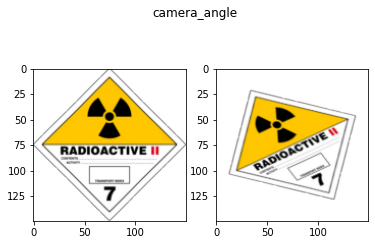

In [8]:
from scipy.ndimage import affine_transform

# Returns a matrix that rotates by angle beta
def T(beta):
    T = [
        [1,0,0],
        [0,cos(beta),-sin(beta)],
        [0,sin(beta),cos(beta)]
    ]
    return np.array(T)

# Define original coordinates, coordinates that will be transformed
S_coord = [
        [1,1,0,0],
        [1,0,1,0],
        [0,0,0,0]
    ]
S_coord = np.array(S_coord)
S_img = np.transpose(75*S_coord[:2,:]+75)


# Changes the camera angle of a picture by a random degree
def camera_angle(img):
    
    angle = 5*pi/12*random()  # Random camera angle
    
    # Generate random orthonormal matrix Q using QR decomposition
    H = np.random.randn(3, 3)
    Q, _ = np.linalg.qr(H)
    
    # Compute Q*T*Q_inv, the transformation matrix T in orthonormal basis Q
    t = T(angle)
    trans = np.dot(np.dot(Q, t), np.transpose(Q))
    
    # Compute mapping S_new
    S_new = np.dot(trans, S_coord)
    S_new = np.transpose(75*S_new[:2,:]+75)

    # Find the homography from S to S_new, and apply the matrix M to the image
    M, mask = cv2.findHomography(S_img, S_new)
    img_dst = cv2.warpPerspective(img, M, None)
    
    return img_dst

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('camera_angle')
ax1.imshow(pics[56])
ax2.imshow(camera_angle(pics[56]))
plt.show()

### Crumple Simulation
A robust model should identify hazmat labels even when the hazmat label is crumpled.

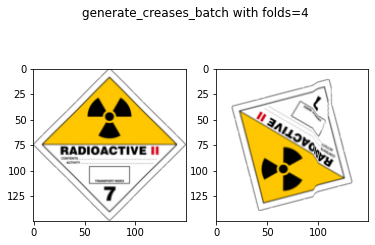

In [9]:
def one_fold(imgs):
    mid = 16+int(random()*96)
    lb = mid - 1 - int(random()*15)
    ub = mid + 1 + int(random()*15)
    squished = random()*4+1
    one = imgs[:,:,:lb]
    _two = imgs[:,:,lb:mid]
    two = resize(_two, (_two.shape[0],_two.shape[1],int(ceil(_two.shape[2]/squished))))
    _three = imgs[:,:,mid:ub]
    three = resize(_three, (_three.shape[0],_three.shape[1],int(ceil(_three.shape[2]/squished))))
    four = imgs[:,:,ub:]
    imgs_new = np.concatenate((one, two, three, four), axis=2)
    return np.clip(imgs_new,0,1)

def generate_creases_batch(imgs, folds = int(ceil(-log(random(),3)-1))):
    if not folds:
        return rotate(imgs, random() * 360, reshape=False, mode='constant', cval=0., axes=(1,2))
    for i in range(folds):
        imgs = rotate(imgs, random() * 360, reshape=False, mode='constant', cval=0., axes=(1,2))
        imgs = one_fold(imgs)
        missing_pixels = 150-imgs.shape[2]
        add_before = int(missing_pixels / 2)
        add_after = missing_pixels - add_before
        zero = np.zeros((imgs.shape[0],imgs.shape[1],add_before, imgs.shape[3]))
        five = np.zeros((imgs.shape[0],imgs.shape[1],add_after, imgs.shape[3]))
        imgs = np.concatenate((zero, imgs, five), axis=2)
    return imgs

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('generate_creases_batch with folds=4')
ax1.imshow(pics[56])
ax2.imshow(generate_creases_batch(pics, folds=2)[56])
plt.show()

###  Simulating Incomplete Labels
In real-world applications, not all HAZMAT labels are intact

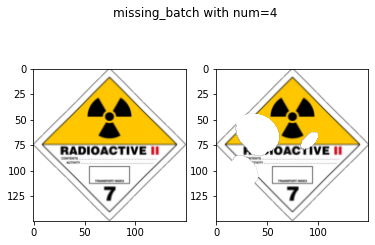

In [10]:
from skimage.draw import ellipse
def one_ellipse_mask():
    mask = np.ones((150,150,4))
    r = 24+80*random()
    c = 24+80*random()
    r_radius = 24*random()
    c_radius = 24*random()
    rotation = -pi+2*pi*random()
    rr, cc = ellipse(r, c, r_radius, c_radius, shape=mask.shape, rotation=rotation)
    mask[rr,cc,:] = 0
    return mask

def missing_batch(imgs, num = int(ceil(-log(random(),3)-1))):
    mask = np.ones((1, 150,150,4)) 
    for i in range(num):
        mask *= one_ellipse_mask() 
    return imgs*mask

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('missing_batch with num=4')
ax1.imshow(pics[56])
ax2.imshow(missing_batch(pics, num=4)[56])
plt.show()

### Obstruction
Sometimes, Hazmat Labels can be obstructed.

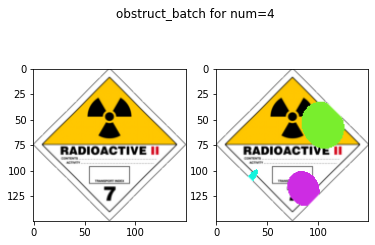

In [11]:
from skimage.draw import ellipse
def color_ellipse_mask(img):
    img_copy = np.copy(img)
    r = 128*random()
    c = 128*random()
    r_radius = 24*random()
    c_radius = 24*random()
    rotation = -pi+2*pi*random()
    rr, cc = ellipse(r, c, r_radius, c_radius, shape=img[0].shape, rotation=rotation)
    img_copy[:, rr,cc,0] = random()
    img_copy[:, rr,cc,1] = random()
    img_copy[:, rr,cc,2] = random()
    return img_copy

def obstruct_batch(imgs, num=int(ceil(-log(random(),3)-1))):
    img_copy = np.copy(imgs)
    for i in range(num):
        img_copy=color_ellipse_mask(img_copy)
    return img_copy

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('obstruct_batch for num=4')
ax1.imshow(pics[56])
ax2.imshow(obstruct_batch(pics, num=4)[56])
plt.show()

### Size/Position Variance

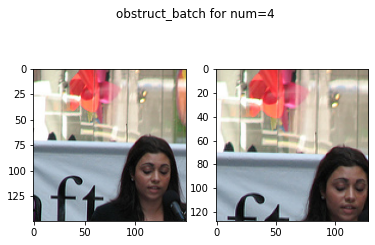

In [17]:
# Takes a random section of the 150 by 150 picture
def to_128_batch(img):
    rand_x = floor(random()*22)
    rand_y = floor(random()*22)
    return img[:, rand_x:rand_x+128, rand_y:rand_y+128, :]
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('obstruct_batch for num=4')
bg = get_bg()
ax1.imshow(bg[0])
ax2.imshow(to_128_batch(bg)[0])
plt.show()

In [18]:
# Reduces the size of a batch of images and pad with 0s
def reduce_size(img):
    batch_size = img.shape[0]
    size_down = int(20*random())
    before = int(size_down/2)
    new_size = 150 - size_down
    new_img = np.zeros((64, new_size, new_size, 4))
    for i in range(batch_size):
        new_img[i]=resize(img[i], (new_size, new_size))
    blank = np.zeros((64, 150, 150, 4))
    blank[:, before: before + new_size, before : before + new_size, :] = new_img
    return blank

## Putting it all together


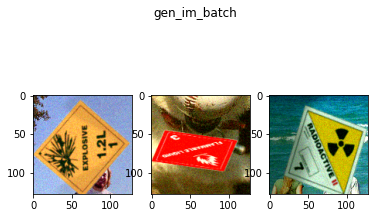

In [19]:
# Generate a batch of training images
def gen_im_batch():
    bg = get_bg()
    imgs = generate_creases_batch(pics)
    imgs = missing_batch(imgs)
    for i in range(62):
        imgs[i] = camera_angle(imgs[i])
    imgs = reduce_size(imgs)
    imgs_rgb, alpha = rgba2rgb_batch(imgs)
    imgs_rgb = hsv_aug_rgb_batch(imgs_rgb)
    combined = (1 - alpha) * bg + imgs_rgb * alpha
    combined = add_noise_batch(combined)
    combined = apply_shadow_batch(combined)
    combined = to_128_batch(combined)
    combined = hsv_aug_rgb_batch(combined)
    combined = obstruct_batch(combined)
    return combined

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('gen_im_batch')
ax1.imshow(gen_im_batch()[20])
ax2.imshow(gen_im_batch()[45])
ax3.imshow(gen_im_batch()[56])
plt.show()

# Section 2: Training
In this section, I will train multiple different deep learning models to learn my synthetically generated dataset.

In [20]:
# Define Labels for the training set
# Note that the class "62" denotes that there is no hazmat label
LABELS = np.linspace(0, 63, 64, dtype = np.uint8)
LABELS[62:64] = 62
LABELS

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 62], dtype=uint8)

In [21]:
# Labels for each batch
LABELS_KERAS = keras.utils.to_categorical(LABELS, num_classes=63)

In [22]:
# Modified from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
# This DataGenerator class generates batches as the model trains
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, fake_size, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=False):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.fake_size = fake_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(fake_size / self.batch_size))

    def __getitem__(self, index):
        # Generate batch
        X, y = self.__data_generation(1)

        return X, y

    def on_epoch_end(self):
        pass
    
    def __data_generation(self, num):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        return gen_im_batch(), LABELS_KERAS

In [23]:
params = {'dim': (128,128),
          'batch_size': 64,
          'n_classes': 63,
          'n_channels': 3
         }

# Datasets
fake_size = 100000

# Generator for training
training_generator = DataGenerator(fake_size, **params)

In [24]:
# Prevent memory hog by allowing gpu to grow
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth=True
#config.gpu_options.per_process_gpu_memory_fraction = 0.6
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
set_session(sess)

# Print available devices to check if GPU is detected by TensorFlow
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())
# Check if GPU is detected by TensorFlow
tf.test.is_gpu_available()


Using TensorFlow backend.


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

## InceptionV3

In [22]:
# Load Pre-trained model trained on ImageNet challenge
from tensorflow.keras.applications import InceptionV3 
model = InceptionV3(include_top=False, weights='imagenet', input_tensor=None, input_shape=(128, 128, 3), pooling='avg', classes=63)
# Add Top Layers
a4 = Dense(63, activation='softmax')(model.output)
# Build new model
model2 = Model(inputs=model.input, outputs=[a4])
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
model2.fit_generator(generator=training_generator,
                    use_multiprocessing=False,
                    epochs=7
                   )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/7
1562/1562 [==============================] - 2711s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.7070 - acc: 0.7712
Epoch 2/7
1562/1562 [==============================] - 2735s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.2466 - acc: 0.9170
Epoch 3/7
1562/1562 [==============================] - 2708s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.1754 - acc: 0.9391
Epoch 4/7
1562/1562 [==============================] - 2686s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.1584 - acc: 0.9443
Epoch 5/7
1562/1562 [==============================] - 2857s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.1300 - acc: 0.9531
Epoch 6/7
1562/1562 [==============================] - 2729s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.1231 - acc: 0.9548
Epoch 7/7
1562/1562 [==============================] - 2644s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.1039 - acc: 0.9618


In [25]:
model2.fit_generator(generator=training_generator,
                    use_multiprocessing=False,
                    epochs=3
                   )

Epoch 1/3
1562/1562 [==============================] - 2691s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.0960 - acc: 0.9692
Epoch 2/3
1562/1562 [==============================] - 2689s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.0832 - acc: 0.9748
Epoch 3/3
1562/1562 [==============================] - 2694s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.0731 - acc: 0.9768


In [28]:
model2.fit_generator(generator=training_generator,
                    use_multiprocessing=False,
                    epochs=2
                   )

Epoch 1/2
1562/1562 [==============================] - 2867s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.0659 - acc: 0.9792
Epoch 2/2
1562/1562 [==============================] - 2858s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.0711 - acc: 0.9778


In [29]:
model2.save("trained_models/InceptionV3")

## ResNet50V2

In [25]:
# Load Pre-trained model trained on ImageNet challenge
from tensorflow.keras.applications import ResNet50V2 
model = ResNet50V2(include_top=False, weights='imagenet', input_tensor=None, input_shape=(128, 128, 3), pooling='avg', classes=63)
# Add Top Layers
a4 = Dense(63, activation='softmax')(model.output)
# Build new model
model2 = Model(inputs=model.input, outputs=[a4])
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
model2.fit_generator(generator=training_generator,
                    use_multiprocessing=False,
                    epochs=7
                   )

Epoch 1/7
1562/1562 [==============================] - 2750s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.9914 - acc: 0.6680
Epoch 2/7
1562/1562 [==============================] - 3039s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.3893 - acc: 0.8703
Epoch 3/7
1562/1562 [==============================] - 3406s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.2724 - acc: 0.9069
Epoch 4/7
1562/1562 [==============================] - 2740s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.2253 - acc: 0.9211
Epoch 5/7
1562/1562 [==============================] - 3577s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.1920 - acc: 0.9324
Epoch 6/7
1562/1562 [==============================] - 3427s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.1759 - acc: 0.9365
Epoch 7/7
1562/1562 [==============================] - 2986s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.1558 - acc: 0.9445


In [22]:
model2.fit_generator(generator=training_generator,
                    use_multiprocessing=False,
                    epochs=3
                   )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/3
1562/1562 [==============================] - 3074s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.1410 - acc: 0.9486
Epoch 2/3
1562/1562 [==============================] - 3042s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.1313 - acc: 0.9529
Epoch 3/3
1562/1562 [==============================] - 2742s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.1126 - acc: 0.9611


In [32]:
model2.fit_generator(generator=training_generator,
                    use_multiprocessing=False,
                    epochs=1
                   )

1562/1562 [==============================] - 2905s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.1006 - acc: 0.9680


In [34]:
model2.fit_generator(generator=training_generator,
                    use_multiprocessing=False,
                    epochs=1
                   )

1562/1562 [==============================] - 2750s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.0978 - acc: 0.9685


In [35]:
model2.save("trained_models/ResNet50V2")

## MobileNetV2

In [28]:
# Load Pre-trained model trained on ImageNet challenge
from tensorflow.keras.applications import MobileNetV2 
model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=None, input_shape=(128, 128, 3), pooling='avg', classes=63)
# Add Top Layers
a4 = Dense(63, activation='softmax')(model.output)
# Build new model
model2 = Model(inputs=model.input, outputs=[a4])
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

9412608/9406464 [==============================] - 0s 0us/step


In [29]:
model2.fit_generator(generator=training_generator,
                    use_multiprocessing=False,
                    epochs=4
                   )

Epoch 1/4
1562/1562 [==============================] - 2798s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.6379 - acc: 0.7968
Epoch 2/4
1562/1562 [==============================] - 2815s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.2833 - acc: 0.9113
Epoch 3/4
1562/1562 [==============================] - 2855s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.2193 - acc: 0.9324
Epoch 4/4
1562/1562 [==============================] - 2896s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.1855 - acc: 0.9429


In [32]:
model2.fit_generator(generator=training_generator,
                    use_multiprocessing=False,
                    epochs=4
                   )

Epoch 1/4
1562/1562 [==============================] - 2863s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.1660 - acc: 0.9489
Epoch 2/4
1562/1562 [==============================] - 2996s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.1427 - acc: 0.9564
Epoch 3/4
1562/1562 [==============================] - 3077s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.1159 - acc: 0.9653
Epoch 4/4
1562/1562 [==============================] - 3024s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.1141 - acc: 0.9655


In [33]:
model2.save("trained_models/MobileNetV2")

## InceptionResNetV2

In [25]:
# Load Pre-trained model trained on ImageNet challenge
from tensorflow.keras.applications import InceptionResNetV2
model = InceptionResNetV2(include_top=False, weights='imagenet', input_tensor=None, input_shape=(128, 128, 3), pooling='avg', classes=63)
# Add Top Layers
a4 = Dense(63, activation='softmax')(model.output)
# Build new model
model2 = Model(inputs=model.input, outputs=[a4])
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
model2.fit_generator(generator=training_generator,
                    use_multiprocessing=False,
                    epochs=5
                   )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
1562/1562 [==============================] - 2541s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.3161 - acc: 0.8937
Epoch 2/5
1562/1562 [==============================] - 2563s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.1034 - acc: 0.9664
Epoch 3/5
1562/1562 [==============================] - 2513s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.0700 - acc: 0.9805
Epoch 4/5
1562/1562 [==============================] - 2532s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.0532 - acc: 0.9856
Epoch 5/5
1562/1562 [==============================] - 2600s 2s/step - batch: 780.5000 - size: 64.0000 - loss: 0.0407 - acc: 0.9892


In [28]:
model2.save("trained_models/InceptionResNetV2")

# Section 3: Testing on real data
Using the HTLID dataset, I tested the models

In [30]:
# Data Generated from the HTLID Dataset. Test set of 600 images
X = np.load("X.npy")
Y = np.load("Y.npy")

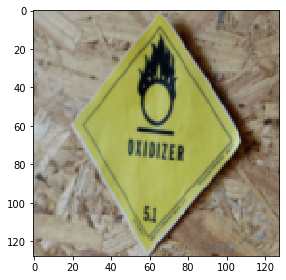

In [38]:
#Example of a testing datapoint
imshow(X[0])

In [43]:
# Load InceptionV3 model and evaluate it on the test set
model = keras.models.load_model('trained_models/InceptionV3')
model.evaluate(X, Y)

[0.9412916396540337, 0.815]

In [42]:
# Load ResNet50V2 model and evaluate it on the test set
model = keras.models.load_model('trained_models/ResNet50V2')
model.evaluate(X, Y)

[1.4115702384524047, 0.6983333]

In [41]:
# Load MobileNetV2 model and evaluate it on the test set
model = keras.models.load_model('trained_models/MobileNetV2')
model.evaluate(X, Y)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


[3.8958726914723716, 0.39666668]

In [31]:
# Load InceptionResNetV2 model and evaluate it on the test set
model = keras.models.load_model('trained_models/InceptionResNetV2')
model.evaluate(X, Y)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


[1.268725271538715, 0.75166667]